# How to use the differents classes from the folder *attention_algorithms*

In [1]:
%load_ext autoreload
%autoreload 2
import os
import matplotlib.pyplot as plt
import torch

from os import path

from training_bert import BertNliLight
from custom_data_set import SnliDataset
from torch.utils.data import DataLoader

from attention_algorithms.raw_attention import RawAttention
from attention_algorithms.heads_role import HeadsRole

from IPython.display import display, HTML  # >> HTML view of the attention

from attention_algorithms.raw_attention import hightlight_txt

In [2]:
cwd = os.getcwd().split(os.path.sep)
while cwd[-1] != "stage_4_gm":
    os.chdir("..")
    cwd = os.getcwd().split(os.path.sep)
print(">> the git rep : ",end="")
print(os.getcwd())

>> the git rep : C:\Users\loicf\Documents\IRISA\stage_4_gm\stage_4_gm


In [3]:
ckp = path.join(".cache","logs","igrida_trained","0","best.ckpt")
model = BertNliLight.load_from_checkpoint(ckp)
model.eval()  # make sure to have the model in eval mod before using it

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


BertNliLight(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)

## The RawAttention class

In [4]:
# the directory where we will store the different figure of this notebook !
plots_folder = os.path.join('.cache', 'plots')
graph_folder = path.join(plots_folder, "attention_test_runs")
if not path.exists(path.join(plots_folder, "attention_test_runs")):
    os.mkdir(path.join(plots_folder, "attention_test_runs"))

In [5]:
# load some data just load one sentence
data_set = SnliDataset(nb_sentences=1, msg=False)
data_loader = DataLoader(data_set, batch_size=1, shuffle=False)

sentences, masks, train_labels = next(iter(data_loader))

print(f">> shape of the sentences : {sentences.shape}")
print(f">> shape of the masks : {masks.shape}")
print(f">> numer of non-masked tokens : {masks.detach().numpy().sum()}")

>> shape of the sentences : torch.Size([1, 150])
>> shape of the masks : torch.Size([1, 150])
>> numer of non-masked tokens : 25


In [6]:
# construct the
print(">> ",end="")
raw_attention_inst = RawAttention(model=model,
                                  input_ids=sentences,
                                  attention_mask=masks,
                                  test_mod=True  # make sure that the attention tensor has the correct structure
                                  )

>> test passed : ✓


In [7]:
print(raw_attention_inst)
# we need to proceed some test to use them

>> the tokens : ['[CLS]', 'a', 'person', 'on', 'a', 'horse', 'jumps', 'over', 'a', 'broken', 'down', 'airplane', '.', '[SEP]', 'a', 'person', 'is', 'training', 'his', 'horse', 'for', 'a', 'competition', '.', '[SEP]']
>> graph set up : False >> NOT ready for inference !


Now we will see the structure of some objects in this class

In [8]:
# derive the heads agregation
raw_attention_inst.heads_agregation(num_head=6,
                                    heads_concat=False)

print(f">> shape of the agregation {raw_attention_inst.att_tens_agr.shape}")

>> shape of the agregation torch.Size([12, 25, 25])


In [9]:
# the graph set up
print(f">> is the graph set up : {raw_attention_inst.set_gr}")
# when we want to use the attention graph we must first set up this graph
raw_attention_inst.set_up_graph(num_head=6,
                                heads_concat=False)

print(f">> agregate tensor shape : {raw_attention_inst.att_tens_agr.shape}")
print(f">> adj matrix shape : {raw_attention_inst.adj_mat.shape}")
print(
    f">> the shapes are good (test1) ? {raw_attention_inst.adj_mat.shape[0] == raw_attention_inst.att_tens_agr.shape[0] * raw_attention_inst.att_tens_agr.shape[1]}")
print(
    f">> the shapes are good (test2) ? {raw_attention_inst.adj_mat.shape[0] == raw_attention_inst.att_tens_agr.shape[0] * raw_attention_inst.att_tens_agr.shape[2]}")

print(f">> the different labels {len(raw_attention_inst.label)}")
print(f">> form of the label : {[d for d in list(raw_attention_inst.label.keys())][16]}")

>> is the graph set up : False
>> agregate tensor shape : torch.Size([12, 25, 25])
>> adj matrix shape : (300, 300)
>> the shapes are good (test1) ? True
>> the shapes are good (test2) ? True
>> the different labels 300
>> form of the label : Layer_0_16


In [10]:
print(raw_attention_inst)
# after the graph set up the raw_attention object is ready for inference

>> the tokens : ['[CLS]', 'a', 'person', 'on', 'a', 'horse', 'jumps', 'over', 'a', 'broken', 'down', 'airplane', '.', '[SEP]', 'a', 'person', 'is', 'training', 'his', 'horse', 'for', 'a', 'competition', '.', '[SEP]']
>> graph set up : True >> ready for inference !


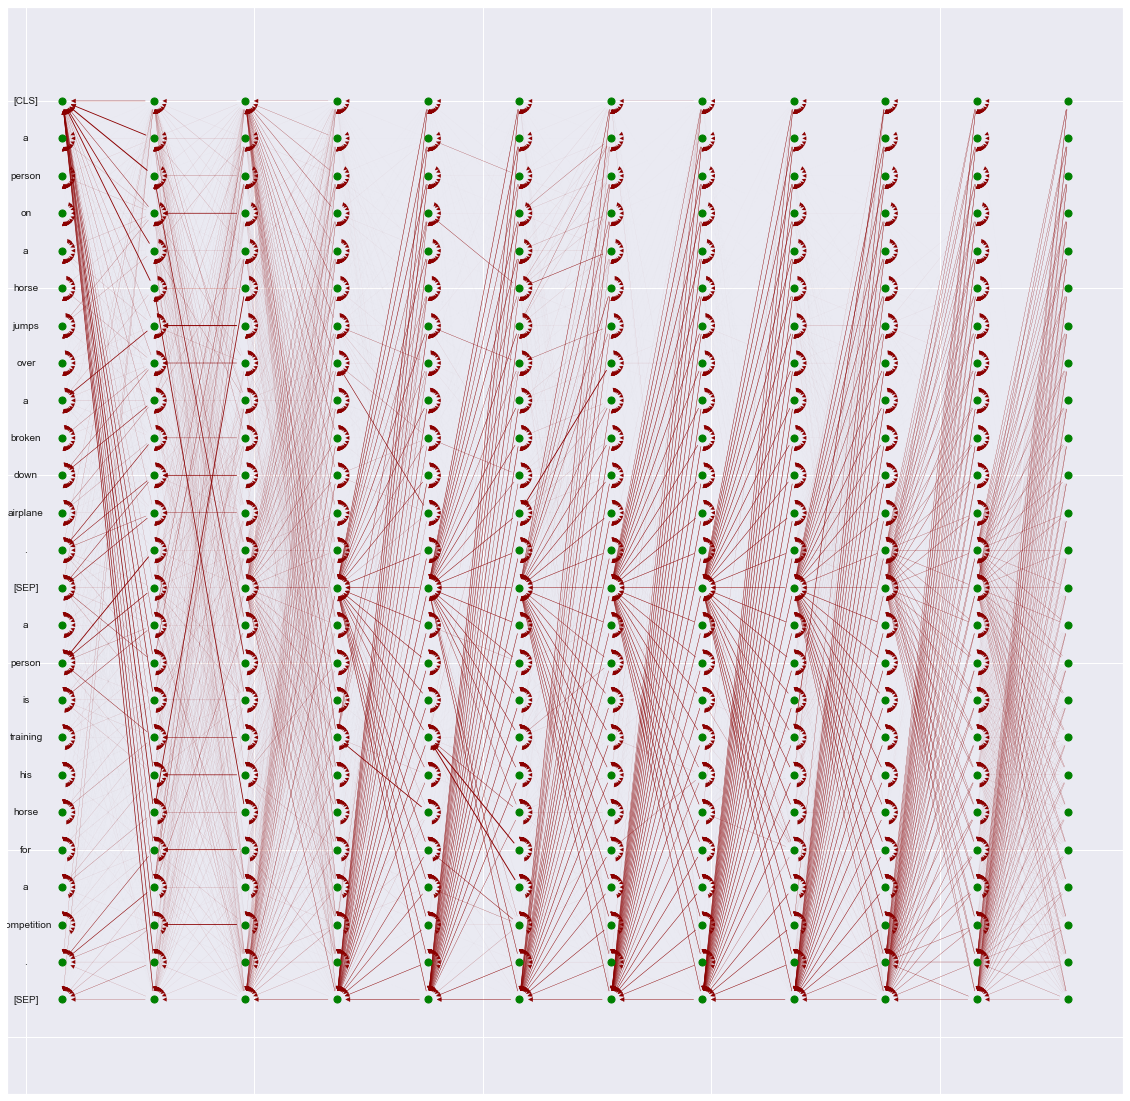

In [11]:
fig = raw_attention_inst.draw_attention_graph()
plt.savefig(path.join(graph_folder, "test_attention_graph_head_6_without_eval_mod.png"))

In [46]:
# the access of the different element
try :
    g = raw_attention_inst["attention_graph"]
    print(f">> {type(g)} >> {len(g.nodes())} nodes")
    att_tens = raw_attention_inst["attention_tensor"]
    print(f">> {type(att_tens)} >> {att_tens.shape}")
    att_tens_agr = raw_attention_inst["attention_tensor_agreg"]
    print(f">> {type(att_tens_agr)} >> {att_tens_agr.shape}")
    buff = raw_attention_inst["something"]
except Exception as e:
    print(f">> type of the exception {type(e)} message of the excpetion : {e}")


>> <class 'networkx.classes.digraph.DiGraph'> >> 300 nodes
>> <class 'torch.Tensor'> >> torch.Size([1, 12, 12, 25, 25])
>> <class 'torch.Tensor'> >> torch.Size([12, 25, 25])
>> type of the exception <class 'attention_algorithms.raw_attention.NoneItemError'> message of the excpetion : please select item in range [attention_graph, attention_tensor, attention_tensor_agreg]


In [21]:
# test of the warning
raw_attention_inst.heads_agregation(num_head=1,
                                    heads_concat=True)

C:\Users\loicf\Documents\IRISA\stage_4_gm\stage_4_gm\attention_algorithms\raw_attention.py:143: UserWarning: The heads number is useless since you are want to proceed heads agregation
  warnings.warn("The heads number is useless since you are want to proceed heads agregation")


## Heads Role

In [12]:
# load some data just load one sentence
data_set = SnliDataset(nb_sentences=500, msg=False)
data_loader = DataLoader(data_set, batch_size=500, shuffle=False)

sentences, masks, train_labels = next(iter(data_loader))

print(f">> shape of the sentences : {sentences.shape}")
print(f">> shape of the masks : {masks.shape}")

>> shape of the sentences : torch.Size([500, 150])
>> shape of the masks : torch.Size([500, 150])


In [13]:
heads_role_inst = HeadsRole(input_ids=sentences, attention_masks=masks)

In [14]:
heads_role_inst.attention_confidence(model)

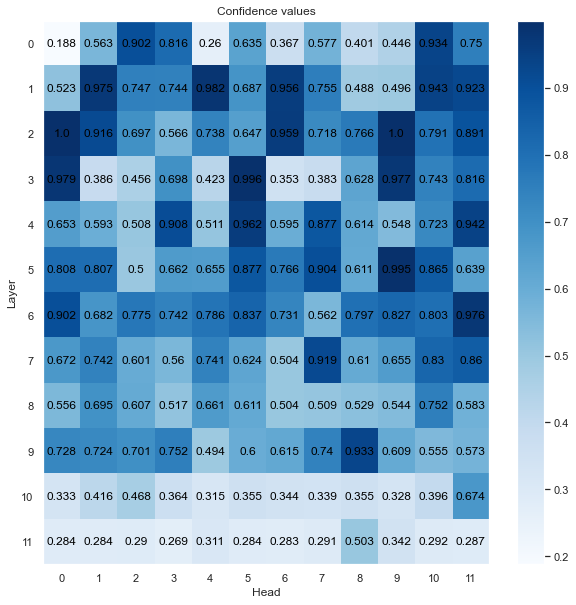

In [15]:
fig = heads_role_inst.plot_confidence()
plt.savefig(path.join(graph_folder,"confidence_map_test.png"))

## Use HTML display to look at the attention

How to see the attention in a sentence on a good way.

In [16]:
tokens = 'An older and younger man smiling.'.split(' ')
attentions = torch.softmax(torch.rand(6), dim=-1)
visual = hightlight_txt(tokens, attentions)

display(HTML('<h3>Example of attention</h3>'))
display(HTML(visual))